In [4]:
!pip install pmdarima


   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ---------------------------------------- 625.1/625.1 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.7 MB 8.3 MB/s eta 0:00:01
   -------------------------------------- - 2.6/2.7 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 7.8 MB/s eta 0:00:00


In [1]:
import pandas as pd

df = pd.read_csv('divorce-rates-annual.csv') 
print(df.columns)


Index(['DataSeries', '2023', '2022', '2021', '2020', '2019', '2018', '2017',
       '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008',
       '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999',
       '1998', '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990',
       '1989', '1988', '1987', '1986', '1985', '1984', '1983', '1982', '1981',
       '1980'],
      dtype='object')


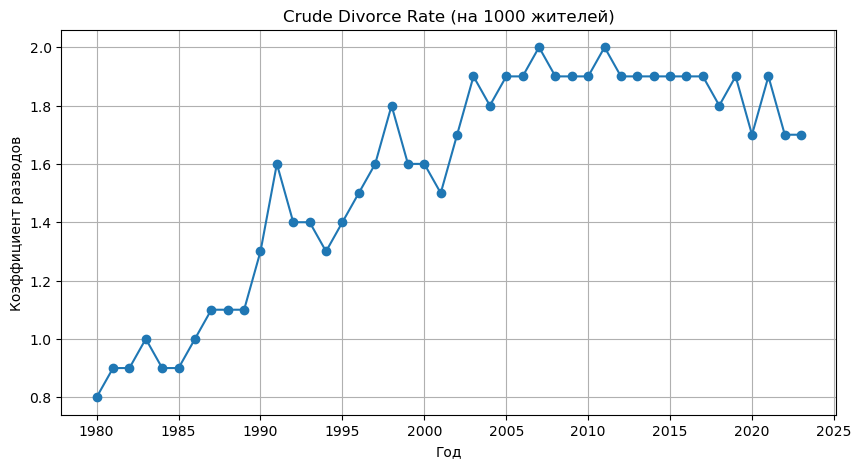

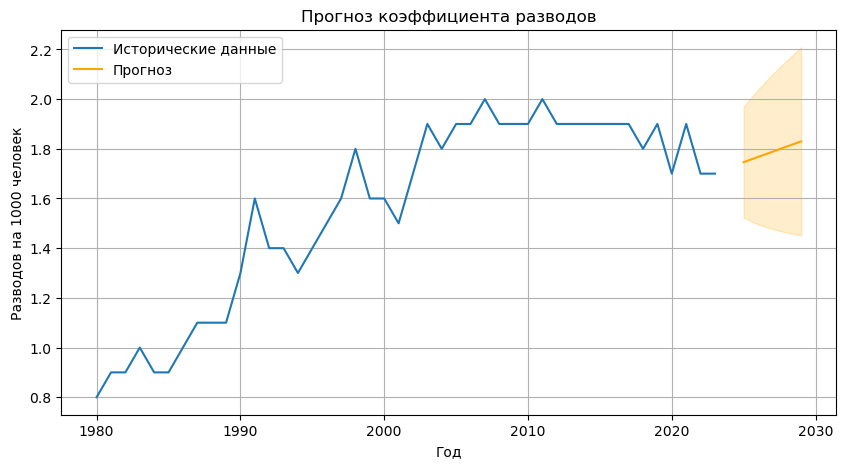

Параметры модели ARIMA:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  32.233
Date:                Thu, 03 Jul 2025   AIC                            -58.467
Time:                        23:19:25   BIC                            -53.183
Sample:                    01-01-1980   HQIC                           -56.518
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0209      0.014      1.534      0.125      -0.006       0.048
ma.L1         -0.3170      0.157     -2.020      0.043      -0.625      -0.009
sigma2         0.0130      0

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

# Загрузка CSV
df_raw = pd.read_csv('divorce-rates-annual.csv')

# Транспонирование: переворачиваем таблицу
df = df_raw.set_index('DataSeries').T

# Переименование колонки
df.rename(columns={
    'Crude Divorce Rate': 'crude_divorce_rate'
}, inplace=True)

# Индексация по году
df.index.name = 'year'
df.reset_index(inplace=True)
df['year'] = df['year'].astype(int)
df['crude_divorce_rate'] = pd.to_numeric(df['crude_divorce_rate'], errors='coerce')

# Создаём временной индекс
df = df.sort_values('year')
df.set_index(pd.to_datetime(df['year'], format='%Y'), inplace=True)

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['crude_divorce_rate'], marker='o')
plt.title('Crude Divorce Rate (на 1000 жителей)')
plt.xlabel('Год')
plt.ylabel('Коэффициент разводов')
plt.grid(True)
plt.show()

# Обучение модели ARIMA
model = pm.auto_arima(df['crude_divorce_rate'], seasonal=False, stepwise=True, suppress_warnings=True)

# Прогноз на 5 лет вперёд
n_years = 5
forecast, conf_int = model.predict(n_periods=n_years, return_conf_int=True)

# Подготовка временной оси
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(years=1), periods=n_years, freq='YE')

# Визуализация прогноза
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['crude_divorce_rate'], label='Исторические данные')
plt.plot(forecast_index, forecast, label='Прогноз', color='orange')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2)
plt.title('Прогноз коэффициента разводов')
plt.xlabel('Год')
plt.ylabel('Разводов на 1000 человек')
plt.legend()
plt.grid(True)
plt.show()

# Выводим статистику модели
print("Параметры модели ARIMA:")
print(model.summary())
print(f"\nПрогноз на {n_years} лет:")
for i, (year, value) in enumerate(zip(forecast_index.year, forecast)):
    print(f"{year}: {value:.2f}")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

# Настройка matplotlib для кириллицы и стиля графиков
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8')


In [7]:
print("=" * 50)
print("АНАЛИЗ ВРЕМЕННЫХ РЯДОВ: КОЭФФИЦИЕНТ РАЗВОДОВ")
print("=" * 50)

df_raw = pd.read_csv('divorce-rates-annual.csv')
df = df_raw.set_index('DataSeries').T

# Переименование колонки
df.rename(columns={'Crude Divorce Rate': 'crude_divorce_rate'}, inplace=True)

# Подготовка данных
df.index.name = 'year'
df.reset_index(inplace=True)
df['year'] = df['year'].astype(int)
df['crude_divorce_rate'] = pd.to_numeric(df['crude_divorce_rate'], errors='coerce')

# Сортировка и создание временного индекса
df = df.sort_values('year')
df.set_index(pd.to_datetime(df['year'], format='%Y'), inplace=True)

# Удаление пропущенных значений
df = df.dropna(subset=['crude_divorce_rate'])

print(f"Период анализа: {df.index.min().year} - {df.index.max().year}")
print(f"Количество наблюдений: {len(df)}")
print(f"Среднее значение: {df['crude_divorce_rate'].mean():.2f}")
print(f"Стандартное отклонение: {df['crude_divorce_rate'].std():.2f}")


АНАЛИЗ ВРЕМЕННЫХ РЯДОВ: КОЭФФИЦИЕНТ РАЗВОДОВ
Период анализа: 1980 - 2023
Количество наблюдений: 44
Среднее значение: 1.56
Стандартное отклонение: 0.38


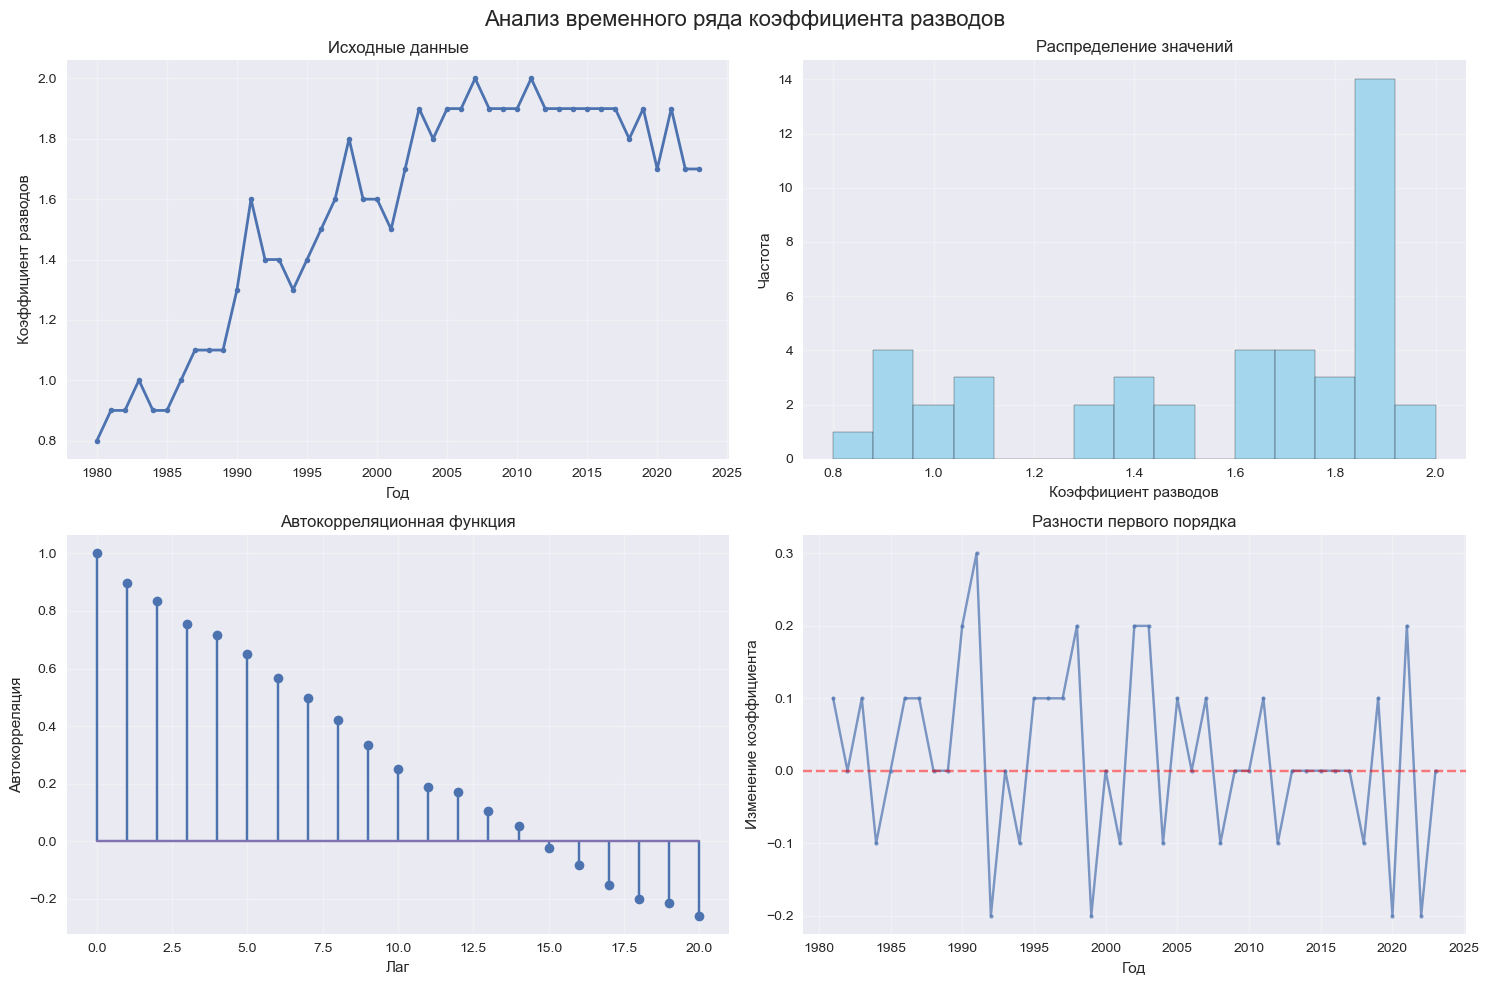

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Анализ временного ряда коэффициента разводов', fontsize=16)

# Исходные данные
axes[0,0].plot(df.index, df['crude_divorce_rate'], marker='o', linewidth=2, markersize=4)
axes[0,0].set_title('Исходные данные')
axes[0,0].set_xlabel('Год')
axes[0,0].set_ylabel('Коэффициент разводов')
axes[0,0].grid(True, alpha=0.3)

# Гистограмма распределения
axes[0,1].hist(df['crude_divorce_rate'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('Распределение значений')
axes[0,1].set_xlabel('Коэффициент разводов')
axes[0,1].set_ylabel('Частота')
axes[0,1].grid(True, alpha=0.3)

# Автокорреляция
from statsmodels.tsa.stattools import acf
autocorr = acf(df['crude_divorce_rate'], nlags=20)
axes[1,0].stem(range(21), autocorr)
axes[1,0].set_title('Автокорреляционная функция')
axes[1,0].set_xlabel('Лаг')
axes[1,0].set_ylabel('Автокорреляция')
axes[1,0].grid(True, alpha=0.3)

# Разности первого порядка
df['diff_1'] = df['crude_divorce_rate'].diff()
axes[1,1].plot(df.index, df['diff_1'], marker='o', markersize=3, alpha=0.7)
axes[1,1].set_title('Разности первого порядка')
axes[1,1].set_xlabel('Год')
axes[1,1].set_ylabel('Изменение коэффициента')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



РАЗЛОЖЕНИЕ ВРЕМЕННОГО РЯДА


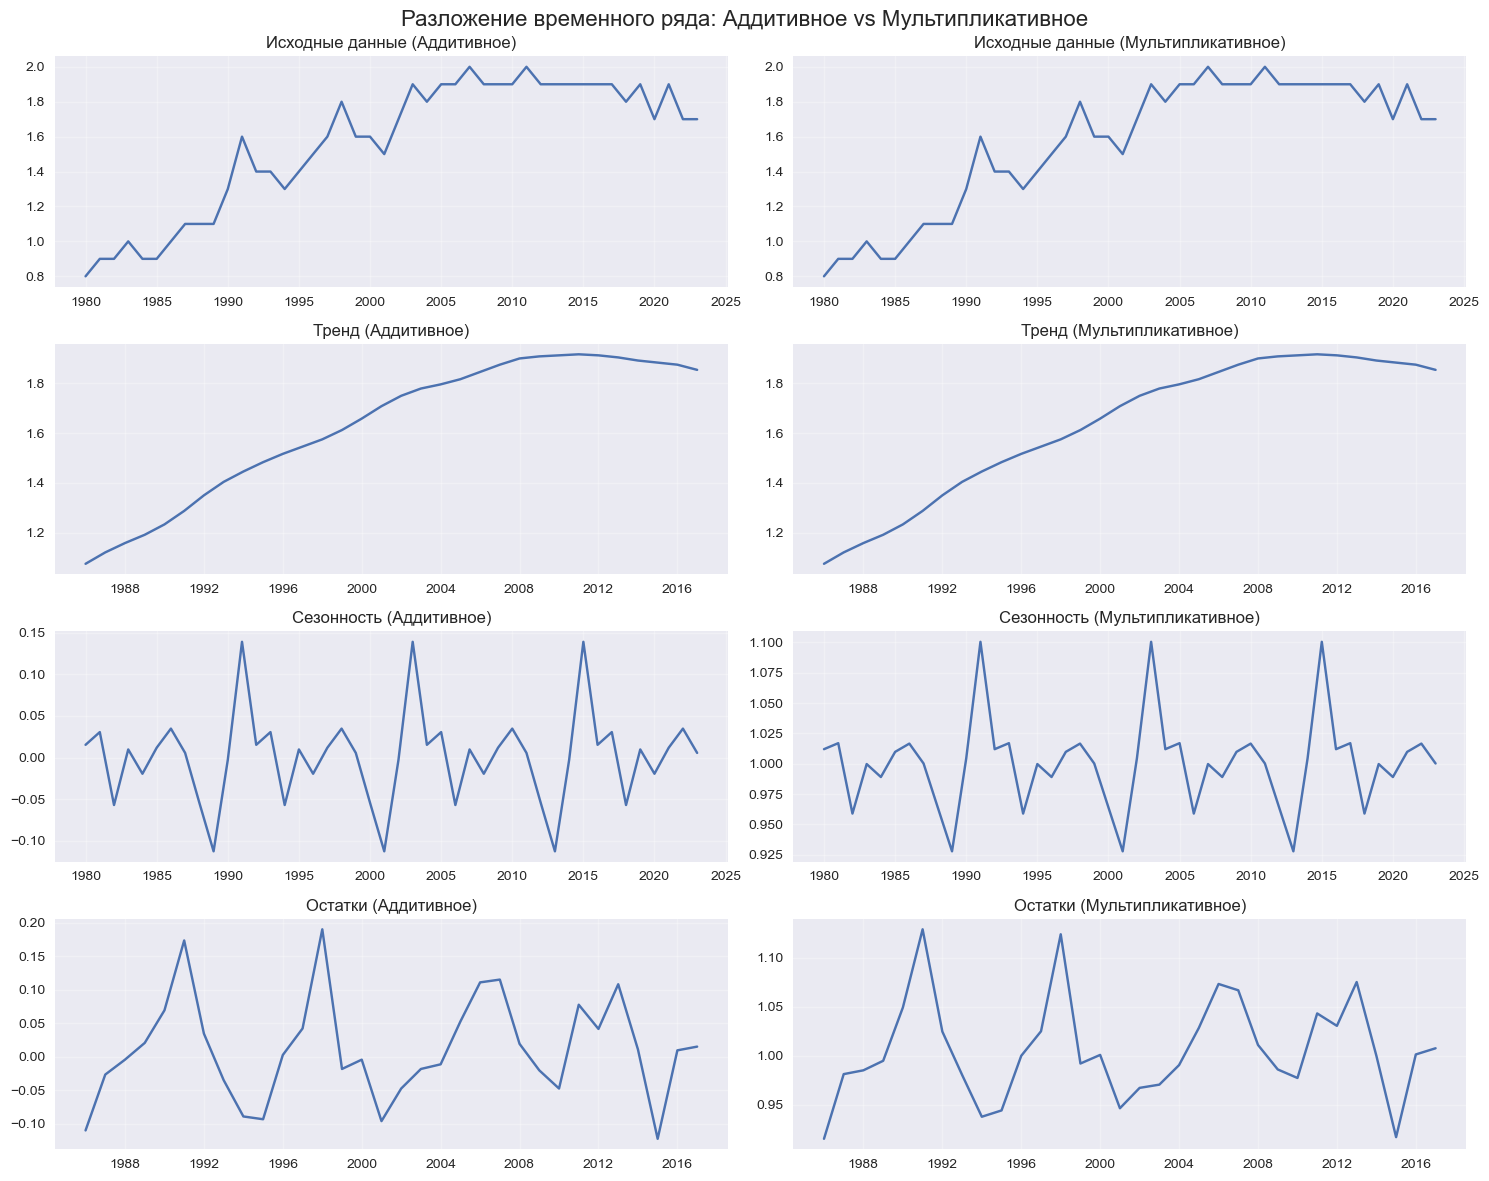

In [11]:
print("\n" + "=" * 30)
print("РАЗЛОЖЕНИЕ ВРЕМЕННОГО РЯДА")
print("=" * 30)

if len(df) >= 24:  # Проверка достаточности данных для сезонного разложения
    try:
        decomposition_add = seasonal_decompose(df['crude_divorce_rate'], model='additive', period=12)
        decomposition_mul = seasonal_decompose(df['crude_divorce_rate'], model='multiplicative', period=12)
        
        fig, axes = plt.subplots(4, 2, figsize=(15, 12))
        fig.suptitle('Разложение временного ряда: Аддитивное vs Мультипликативное', fontsize=16)
        
        # Аддитивное
        axes[0,0].plot(decomposition_add.observed)
        axes[0,0].set_title('Исходные данные (Аддитивное)')
        axes[0,0].grid(True, alpha=0.3)
        
        axes[1,0].plot(decomposition_add.trend)
        axes[1,0].set_title('Тренд (Аддитивное)')
        axes[1,0].grid(True, alpha=0.3)
        
        axes[2,0].plot(decomposition_add.seasonal)
        axes[2,0].set_title('Сезонность (Аддитивное)')
        axes[2,0].grid(True, alpha=0.3)
        
        axes[3,0].plot(decomposition_add.resid)
        axes[3,0].set_title('Остатки (Аддитивное)')
        axes[3,0].grid(True, alpha=0.3)
        
        # Мультипликативное
        axes[0,1].plot(decomposition_mul.observed)
        axes[0,1].set_title('Исходные данные (Мультипликативное)')
        axes[0,1].grid(True, alpha=0.3)
        
        axes[1,1].plot(decomposition_mul.trend)
        axes[1,1].set_title('Тренд (Мультипликативное)')
        axes[1,1].grid(True, alpha=0.3)
        
        axes[2,1].plot(decomposition_mul.seasonal)
        axes[2,1].set_title('Сезонность (Мультипликативное)')
        axes[2,1].grid(True, alpha=0.3)
        
        axes[3,1].plot(decomposition_mul.resid)
        axes[3,1].set_title('Остатки (Мультипликативное)')
        axes[3,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Сезонное разложение недоступно: {e}")
        from scipy import signal
        trend = signal.savgol_filter(df['crude_divorce_rate'], window_length=5, polyorder=2)
        df['trend'] = trend
        df['detrended'] = df['crude_divorce_rate'] - trend
        
        fig, axes = plt.subplots(3, 1, figsize=(12, 8))
        axes[0].plot(df.index, df['crude_divorce_rate'], label='Исходные данные')
        axes[0].plot(df.index, df['trend'], label='Тренд', color='red')
        axes[0].set_title('Исходные данные и тренд')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(df.index, df['trend'], color='red')
        axes[1].set_title('Извлеченный тренд')
        axes[1].grid(True, alpha=0.3)
        
        axes[2].plot(df.index, df['detrended'])
        axes[2].set_title('Данные без тренда')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()



МЕТОДЫ СГЛАЖИВАНИЯ


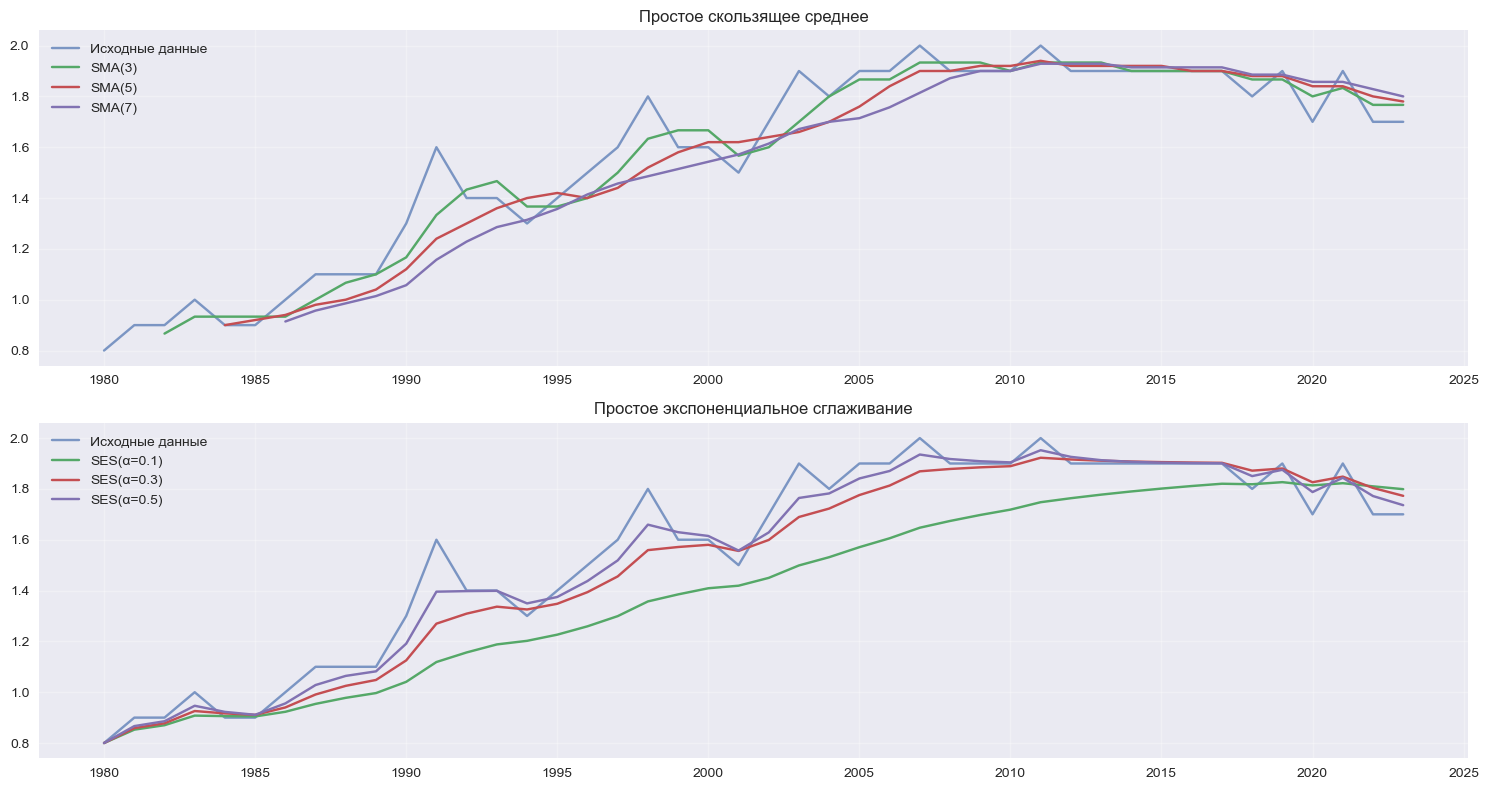

In [48]:
print("\n" + "=" * 30)
print("МЕТОДЫ СГЛАЖИВАНИЯ")
print("=" * 30)

window_sizes = [3, 5, 7]
for window in window_sizes:
    df[f'SMA_{window}'] = df['crude_divorce_rate'].rolling(window=window).mean()

alpha_values = [0.1, 0.3, 0.5]
for alpha in alpha_values:
    df[f'SES_{alpha}'] = df['crude_divorce_rate'].ewm(alpha=alpha).mean()

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Скользящее среднее
axes[0].plot(df.index, df['crude_divorce_rate'], label='Исходные данные', alpha=0.7)
for window in window_sizes:
    axes[0].plot(df.index, df[f'SMA_{window}'], label=f'SMA({window})')
axes[0].set_title('Простое скользящее среднее')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Экспоненциальное сглаживание
axes[1].plot(df.index, df['crude_divorce_rate'], label='Исходные данные', alpha=0.7)
for alpha in alpha_values:
    axes[1].plot(df.index, df[f'SES_{alpha}'], label=f'SES(α={alpha})')
axes[1].set_title('Простое экспоненциальное сглаживание')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



МОДЕЛИ ХОЛЬТА-ВИНТЕРСА


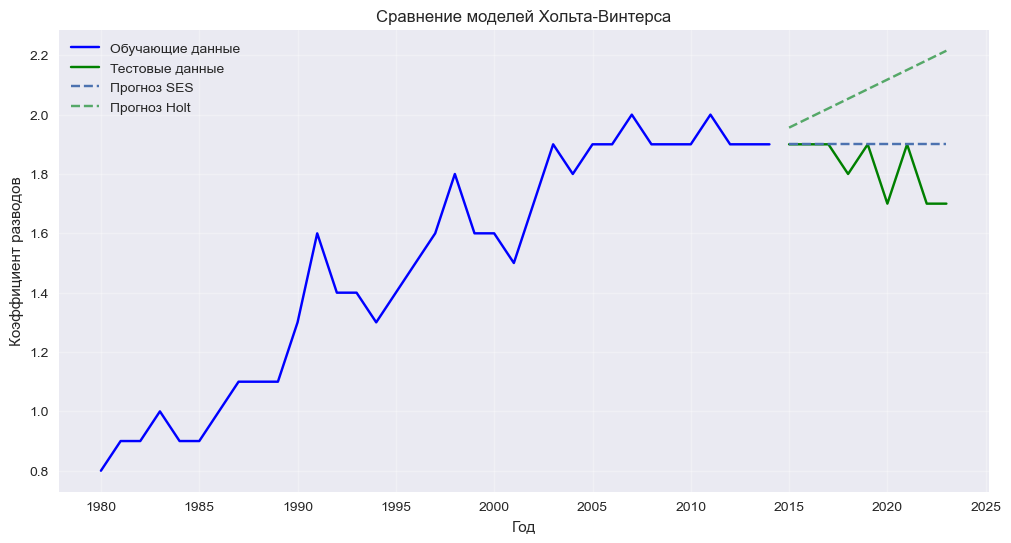


Метрики качества моделей:
----------------------------------------
SES       : RMSE=0.120, MAPE=4.5%
Holt      : RMSE=0.309, MAPE=14.9%


In [13]:
print("\n" + "=" * 30)
print("МОДЕЛИ ХОЛЬТА-ВИНТЕРСА")
print("=" * 30)

train_size = int(len(df) * 0.8)
train_data = df['crude_divorce_rate'].iloc[:train_size]
test_data = df['crude_divorce_rate'].iloc[train_size:]

models = {}
forecasts = {}

models['SES'] = ExponentialSmoothing(train_data, trend=None, seasonal=None).fit()
forecasts['SES'] = models['SES'].forecast(len(test_data))

models['Holt'] = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()
forecasts['Holt'] = models['Holt'].forecast(len(test_data))

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Обучающие данные', color='blue')
plt.plot(test_data.index, test_data, label='Тестовые данные', color='green')

for model_name, forecast in forecasts.items():
    plt.plot(test_data.index, forecast, label=f'Прогноз {model_name}', linestyle='--')

plt.title('Сравнение моделей Хольта-Винтерса')
plt.xlabel('Год')
plt.ylabel('Коэффициент разводов')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nМетрики качества моделей:")
print("-" * 40)
for model_name, forecast in forecasts.items():
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test_data, forecast) * 100
    print(f"{model_name:10s}: RMSE={rmse:.3f}, MAPE={mape:.1f}%")
